

# Integración de Time-MoE y PINNs para Estrategias de Trading Basadas en Datos de Alta Frecuencia del Order Book

## Tabla de Contenidos

1. [Introducción](#introducción)
2. [Definiciones y Formulaciones Matemáticas](#definiciones-y-formulaciones-matemáticas)
    - [Estrategia de Trading](#estrategia-de-trading)
    - [Retorno de un Período](#retorno-de-un-período)
    - [Estimador \(A_T\)](#estimador-at)
    - [Estimador \(B_T\)](#estimador-bt)
    - [Varianza de \(A_T - B_T\) Bajo Hipótesis Nula](#varianza-de-at--bt-bajo-hipótesis-nula)
    - [Estadística de Prueba de Rentabilidad Excesiva (EP)](#estadística-de-prueba-de-rentabilidad-excesiva-ep)
    - [Estadística de Prueba de Precisión Direccional (DA)](#estadística-de-prueba-de-precisión-direccional-da)
    - [Ecuaciones de Modelos de Referencia](#ecuaciones-de-modelos-de-referencia)
3. [Arquitectura Time-MoE desde Hugging Face](#arquitectura-time-moe-desde-hugging-face)
    - [Descripción General de Time-MoE](#descripción-general-de-time-moe)
    - [Implementación desde Hugging Face](#implementación-desde-hugging-face)
    - [Adaptación para Datos de Order Book](#adaptación-para-datos-de-order-book)
    - [Código de Implementación de Time-MoE](#código-de-implementación-de-time-moe)
4. [Integración de PINNs en la Función de Pérdida](#integración-de-pinns-en-la-función-de-pérdida)
    - [Conceptos Básicos de PINNs](#conceptos-básicos-de-pinns)
    - [Incorporación de Rentabilidad en la Función de Pérdida](#incorporación-de-rentabilidad-en-la-función-de-pérdida)
    - [Formulación de la Pérdida de Rentabilidad](#formulación-de-la-pérdida-de-rentabilidad)
    - [Implementación de la Función de Pérdida](#implementación-de-la-función-de-pérdida)
5. [Definición Completa del Modelo](#definición-completa-del-modelo)
    - [Componentes del Modelo](#componentes-del-modelo)
    - [Arquitectura Detallada](#arquitectura-detallada)
    - [Código de Definición del Modelo](#código-de-definición-del-modelo)
6. [Entrenamiento del Modelo](#entrenamiento-del-modelo)
    - [Preparación de Datos](#preparación-de-datos)
    - [Configuración del Entrenamiento](#configuración-del-entrenamiento)
    - [Proceso de Entrenamiento](#proceso-de-entrenamiento)
    - [Código de Entrenamiento](#código-de-entrenamiento)
7. [Prueba de Predictabilidad](#prueba-de-predictabilidad)
    - [Objetivo](#objetivo)
    - [Estadísticas de Prueba](#estadísticas-de-prueba)
    - [Hipótesis de Prueba](#hipótesis-de-prueba)
    - [Procedimiento de Prueba](#procedimiento-de-prueba)
    - [Código de Prueba de Predictabilidad](#código-de-prueba-de-predictabilidad)
8. [Evaluación y Validación](#evaluación-y-validación)
    - [Desempeño Fuera de Muestra](#desempeño-fuera-de-muestra)
    - [Pruebas Estadísticas](#pruebas-estadísticas)
    - [Pruebas de Robustez](#pruebas-de-robustez)
9. [Conclusión](#conclusión)
10. [Referencias](#referencias)

---




## Introducción

En finanzas cuantitativas, la predicción precisa de los rendimientos de activos es crucial para desarrollar estrategias de trading efectivas. Los datos de alta frecuencia del **Order Book** ofrecen una rica fuente de información que puede ser explotada mediante modelos avanzados de aprendizaje profundo. Este documento presenta una **arquitectura híbrida** que combina los **Modelos de Mezcla de Expertos Temporales (Time-MoE)** de Hugging Face con un enfoque inspirado en **Physics-Informed Neural Networks (PINNs)**. Esta integración busca optimizar la rentabilidad de las estrategias de trading, garantizando que las predicciones no solo sean precisas, sino que también cumplan con restricciones financieras específicas.

---




## Definiciones y Formulaciones Matemáticas

### Estrategia de Trading

**Descripción:**

La estrategia de trading se define de la siguiente manera:

- Si el pronóstico del rendimiento futuro ($\hat{y}_t$) es positivo o cero, se compra acciones.
- Si el pronóstico es negativo, se venden acciones.

---


### Retorno de un Período

**Descripción:**

El retorno de un período ($r_t$) se calcula multiplicando la señal de la estrategia ($\text{sign}(\hat{y}_t)$) por el rendimiento real ($y_t$).

---




### Estimador $A_T$

**Descripción:**

El estimador $A_T$ representa el retorno promedio de la estrategia de trading sobre $T$ períodos.

---




### Estimador $B_T$

**Descripción:**

El estimador $B_T$ representa el retorno promedio de una estrategia de referencia aleatoria.

---


### Varianza de $A_T - B_T$ Bajo Hipótesis Nula

**Descripción:**

Bajo la hipótesis nula de no predictabilidad, la varianza de $A_T - B_T$ se estima utilizando un estimador específico basado en los datos observados.

---


### Estadística de Prueba de Rentabilidad Excesiva (EP)

**Descripción:**

La estadística EP se utiliza para determinar si la estrategia de trading supera significativamente al benchmark.

---


### Ecuaciones de Modelos de Referencia

#### Modelo de Autoregresión Lineal

**Descripción:**

Modelo básico que utiliza el rendimiento pasado para predecir el rendimiento futuro.

---


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -140.872
Date:                Wed, 23 Oct 2024   AIC                            287.744
Time:                        01:35:59   BIC                            295.559
Sample:                             0   HQIC                           290.907
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0857      0.236      0.363      0.716      -0.377       0.548
ar.L1          0.5800      0.077      7.500      0.000       0.428       0.732
sigma2         0.9757      0.152      6.433      0.0

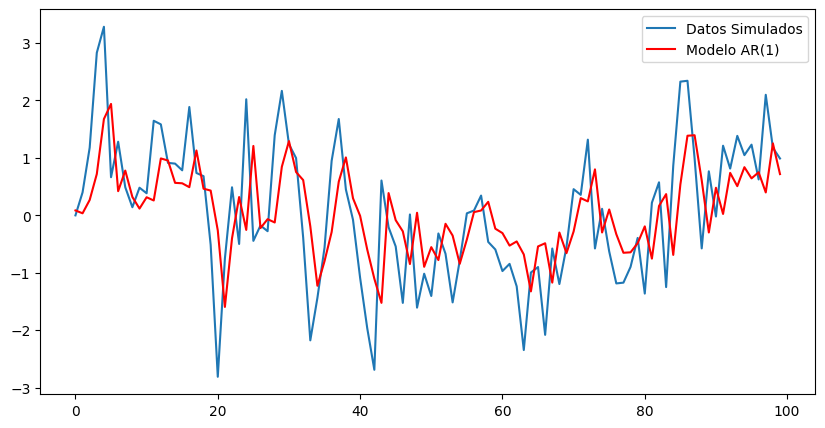

In [ ]:
# Ejemplo de implementación de un Modelo Autoregresivo Lineal (Modelo de Referencia)
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Generar datos simulados
np.random.seed(0)
T = 100
alpha = 0.5
epsilon = np.random.normal(0, 1, T)
y = np.zeros(T)
for t in range(1, T):
    y[t] = alpha * y[t-1] + epsilon[t]

# Ajustar el modelo AR(1)
model = sm.tsa.ARIMA(y, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())

# Graficar los datos
plt.figure(figsize=(10,5))
plt.plot(y, label='Datos Simulados')
plt.plot(model_fit.fittedvalues, label='Modelo AR(1)', color='red')
plt.legend()
plt.show()

## Hiperparámetros


1. **Tasa de Aprendizaje ($\lambda_1$):** Controla la velocidad a la que el modelo actualiza sus pesos durante el entrenamiento.
2. **Tamaño del Batch:** Número de muestras procesadas antes de actualizar los pesos del modelo.
3. **Número de Épocas:** Cantidad de veces que el modelo pasará por todo el conjunto de datos durante el entrenamiento.
4. **Lambda Pred ($\lambda_{\text{pred}}$):** Peso asignado al error de predicción en la función de pérdida total.
5. **Lambda Rent ($\lambda_{\text{rent}}$):** Peso asignado a la penalización de rentabilidad en la función de pérdida total.
6. **Epsilon ($\epsilon$):** Margen mínimo de rentabilidad requerido.
7. **Tamaño de Entrada:** Número de características de entrada al modelo.
8. **Tamaño Oculto:** Dimensionalidad de las capas ocultas en la arquitectura Time-MoE.
9. **Número de Expertos:** Cantidad de submodelos especializados en la arquitectura Time-MoE.
10. **Número de Expertos por Token:** Número de expertos que procesan cada token de entrada.
11. **Número de Capas Ocultas:** Profundidad de la red neuronal.
12. **Número de Cabezas de Atención:** Cantidad de cabezas en el mecanismo de atención.
13. **Tamaño Intermedio:** Dimensionalidad de las capas intermedias en el modelo.
14. **Función de Activación Oculta:** Función no lineal utilizada en las capas ocultas ${gelu}$ en este caso.
15. **Epsilon para RMSNorm:** Parámetro de regularización para la normalización RMS.
16. **Máximo de Posiciones Embedding:** Número máximo de posiciones que el modelo puede procesar.
17. **Aplicar Pérdida Auxiliar:** Indicador de si se aplica una pérdida auxiliar para balancear la carga entre expertos.
18. **Factor de Pérdida Auxiliar del Router:** Escala de la pérdida auxiliar.
19. **Horizonte de Predicción:** Número de períodos futuros que el modelo predice.
20. **Tamaño de Entrada Financiera:** Dimensionalidad de la entrada financiera.
21. **Usar Capa Densa:** Indicador de si se utilizan capas densas o esparsas en el modelo.





# Arquitectura Time-MoE desde Hugging Face

### Descripción General de Time-MoE

Los **Modelos de Mezcla de Expertos Temporales (Time-MoE)** son variantes de los **Modelos de Mezcla de Expertos (MoE)** diseñados específicamente para manejar datos de series temporales complejas y de alta dimensionalidad. La arquitectura se compone de múltiples "expertos" (submodelos) que se especializan en diferentes aspectos o segmentos de la serie temporal, junto con un mecanismo de "gate" que asigna dinámicamente las entradas a los expertos más adecuados en cada punto temporal.

### Implementación desde Hugging Face

Hugging Face proporciona implementaciones optimizadas de **Time-MoE** que facilitan su integración en proyectos de aprendizaje profundo. La arquitectura estándar de Time-MoE incluye:

- **Expertos (Experts)**: Subredes neuronales especializadas que procesan diferentes partes o contextos de la serie temporal.
- **Gate (Puerta)**: Mecanismo que determina qué expertos deben activarse para cada punto temporal.
- **Capa de Agregación**: Combina las salidas de los expertos seleccionados para producir la predicción final.

### Adaptación para Datos de Order Book

Para aplicar **Time-MoE** en el contexto de trading con datos de **Order Book**, es necesario considerar los siguientes aspectos:

1. **Alta Dimensionalidad**: Con más de 500 activos, cada uno con múltiples niveles de profundidad en el Order Book, la arquitectura debe ser capaz de manejar esta alta dimensionalidad.
2. **Contexto Temporal**: Las dinámicas del mercado cambian rápidamente, por lo que el mecanismo de gate debe adaptarse a contextos temporales variables.
3. **Eficiencia Computacional**: Dada la alta frecuencia de los datos, la arquitectura debe ser eficiente para permitir el procesamiento en tiempo real.

### Código de Implementación de Time-MoE

A continuación, se presenta un ejemplo de cómo cargar y adaptar un modelo **Time-MoE** desde Hugging Face para datos de Order Book.



In [ ]:
# modeling_time_moe.py
#CODIGO COMPLETO: https://huggingface.co/Maple728/TimeMoE-50M/blob/main/modeling_time_moe.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class MixtureOfExperts(nn.Module):
    """
    Implementación de una Mezcla de Expertos (MoE).
    """
    def __init__(self, hidden_size, num_experts, num_experts_per_tok, use_dense=False):
        super(MixtureOfExperts, self).__init__()
        self.num_experts = num_experts
        self.num_experts_per_tok = num_experts_per_tok
        self.use_dense = use_dense

        # Definir los expertos
        self.experts = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_experts)])

        # Definir el enrutador (router)
        self.router = nn.Linear(hidden_size, num_experts * num_experts_per_tok)

    def forward(self, x):
        """
        Forward pass de la Mezcla de Expertos.

        Args:
            x (torch.Tensor): Entrada de forma [B, T, hidden_size]

        Returns:
            torch.Tensor: Salida de forma [B, T, hidden_size]
        """
        B, T, H = x.size()

        # Enrutamiento
        router_logits = self.router(x)  # [B, T, num_experts * num_experts_per_tok]
        router_probs = F.softmax(router_logits, dim=-1)  # [B, T, num_experts * num_experts_per_tok]
        router_probs = router_probs.view(B, T, self.num_experts, self.num_experts_per_tok)  # [B, T, num_experts, num_experts_per_tok]

        # Asignar expertos
        outputs = []
        for i in range(self.num_experts):
            for j in range(self.num_experts_per_tok):
                prob = router_probs[:, :, i, j].unsqueeze(-1)  # [B, T, 1]
                expert = self.experts[i]
                expert_output = expert(x)  # [B, T, hidden_size]
                outputs.append(prob * expert_output)  # [B, T, hidden_size]

        # Sumar las salidas de los expertos
        x = torch.stack(outputs, dim=-2).sum(dim=-2)  # [B, T, hidden_size]

        return x

class TimeMoeModel(nn.Module):
    """
    Modelo Time-MoE personalizado.
    """
    def __init__(self, config):
        super(TimeMoeModel, self).__init__()
        self.config = config

        # Capa de entrada
        self.input_layer = nn.Linear(config.input_size, config.hidden_size)

        # Capas ocultas
        self.hidden_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=config.hidden_size,
                nhead=config.num_attention_heads,
                dim_feedforward=config.intermediate_size,
                activation=config.hidden_act
            ) for _ in range(config.num_hidden_layers)
        ])

        # Capa de normalización RMS
        self.rms_norm = nn.LayerNorm(config.hidden_size, eps=config.rms_norm_eps)

        # Mezcla de expertos
        self.moe = MixtureOfExperts(
            hidden_size=config.hidden_size,
            num_experts=config.num_experts,
            num_experts_per_tok=config.num_experts_per_tok,
            use_dense=config.use_dense
        )

        # Positional embeddings
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)

    def forward(self, x):
        """
        Forward pass del modelo Time-MoE.

        Args:
            x (torch.Tensor): Entrada de forma [B, T, F]

        Returns:
            torch.Tensor: Representaciones ocultas [B, T, hidden_size]
        """
        B, T, F = x.size()

        # Capa de entrada
        x = self.input_layer(x)  # [B, T, hidden_size]

        # Añadir embeddings posicionales
        positions = torch.arange(0, T, device=x.device).unsqueeze(0).expand(B, T)  # [B, T]
        pos_emb = self.position_embeddings(positions)  # [B, T, hidden_size]
        x = x + pos_emb  # [B, T, hidden_size]

        # Capas ocultas
        for layer in self.hidden_layers:
            x = layer(x)  # [B, T, hidden_size]

        # Normalización RMS
        x = self.rms_norm(x)  # [B, T, hidden_size]

        # Mezcla de Expertos
        x = self.moe(x)  # [B, T, hidden_size]

        return x


In [ ]:
# configuration_time_moe.py

from dataclasses import dataclass
from typing import List

@dataclass
class TimeMoeConfig:
    input_size: int = 50                # Número de características de entrada
    hidden_size: int = 1024             # Tamaño de la capa oculta
    num_experts: int = 8                 # Número de expertos
    num_experts_per_tok: int = 2         # Número de expertos por token
    num_hidden_layers: int = 6           # Número de capas del modelo
    num_attention_heads: int = 16        # Número de cabezas de atención
    intermediate_size: int = 4096        # Tamaño de la capa intermedia
    hidden_act: str = 'gelu'             # Función de activación
    rms_norm_eps: float = 1e-6           # Parámetro epsilon para RMSNorm
    max_position_embeddings: int = 2048  # Máximo de posiciones
    apply_aux_loss: bool = True          # Aplicar pérdida auxiliar para balanceo de carga
    router_aux_loss_factor: float = 0.1   # Factor de escala para la pérdida auxiliar
    horizon_lengths: List[int] = (1,)      # Horizonte de predicción
    input_size_financial: int = 1         # Tamaño de la entrada financiera
    use_dense: bool = False               # Uso de capas densas o esparsas


In [ ]:
# Definición completa de TimeMoeTradingModel

import torch
import torch.nn as nn
from configuration_time_moe import TimeMoeConfig
from modeling_time_moe import TimeMoeModel

# configuration_time_moe.py

from dataclasses import dataclass
from typing import List


# Cargar el modelo Time-MoE personalizado
time_moe_model = TimeMoeModel(config)

# Definir una capa de salida para predicción
class TimeMoeOutputLayer(nn.Module):
    def __init__(self, hidden_size, input_size=1, horizon_length=1):
        super(TimeMoeOutputLayer, self).__init__()
        self.linear = nn.Linear(hidden_size, input_size * horizon_length, bias=False)

    def forward(self, x):
        return self.linear(x)

# Integrar la capa de salida en el modelo
class TimeMoeTradingModel(nn.Module):
    def __init__(self, config):
        super(TimeMoeTradingModel, self).__init__()
        self.time_moe = time_moe_model
        self.output_layer = TimeMoeOutputLayer(
            hidden_size=config.hidden_size,
            input_size=config.input_size_financial,
            horizon_length=config.horizon_lengths[0]
        )

    def forward(self, x):
        """
        Forward pass del modelo TimeMoeTradingModel.

        Args:
            x (torch.Tensor): Datos de entrada, forma [B, T, F]

        Returns:
            torch.Tensor: Predicciones del rendimiento, forma [B, T, 1]
        """
        moe_output = self.time_moe(x)  # Obtener las representaciones ocultas [B, T, hidden_size]
        predictions = self.output_layer(moe_output)  # [B, T, 1]
        return predictions

# Inicializar el modelo completo
trading_model = TimeMoeTradingModel(config)


In [ ]:
# load_model.py

import torch
from safetensors.torch import load_file
from main_model import trading_model

def load_pretrained_weights(model, weight_path):
    """
    Carga los pesos preentrenados en el modelo.

    Args:
        model (nn.Module): Modelo PyTorch.
        weight_path (str): Ruta al archivo de pesos (.safetensors).

    Returns:
        nn.Module: Modelo con pesos cargados.
    """
    state_dict = load_file(weight_path)
    model.load_state_dict(state_dict)
    return model

# Ruta al archivo de pesos
weight_path = "path/to/model.safetensors"  # Reemplaza con la ruta correcta

# Cargar los pesos en el modelo
trading_model = load_pretrained_weights(trading_model, weight_path)

# Mover el modelo al dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trading_model.to(device)


## Integración de PINNs en la Función de Pérdida

### Conceptos Básicos de PINNs

Las **Physics-Informed Neural Networks (PINNs)** integran conocimiento previo sobre el dominio, típicamente en forma de ecuaciones diferenciales, en el entrenamiento de redes neuronales. Este enfoque asegura que las predicciones del modelo no solo minimicen el error de predicción sino que también respeten leyes físicas o restricciones específicas.

En el contexto de estrategias de trading, las restricciones pueden incluir reglas financieras, límites de riesgo o condiciones de rentabilidad mínima. Inspirándonos en PINNs, incorporamos restricciones financieras directamente en la función de pérdida para guiar el entrenamiento del modelo hacia soluciones que no solo sean precisas, sino también económicamente viables.

### Incorporación de Rentabilidad en la Función de Pérdida

La función de pérdida total $L$ se define como una combinación del error de predicción y una penalización basada en la rentabilidad de la estrategia de trading:

$$
L = \lambda_1 L_{\text{predicción}} + \lambda_2 L_{\text{rentabilidad}}
$$

Donde:

- **$L_{\text{predicción}}$**: Error de predicción, típicamente **Mean Squared Error (MSE)**.
- **$L_{\text{rentabilidad}}$**: Penalización basada en la diferencia entre la rentabilidad obtenida y un benchmark.
- **$\lambda_1, \lambda_2$**: Parámetros de regularización que controlan la importancia relativa de cada término en la optimización.

### Formulación de la Pérdida de Rentabilidad

La pérdida de rentabilidad se define para asegurar que las predicciones generen rendimientos superiores a un benchmark establecido:

$$
L_{\text{rentabilidad}} = \left( A_T - B_T \right)^2
$$

Donde:

- **$A_T$**: Rentabilidad obtenida por la estrategia de trading.
  
  $$
  A_T = \frac{1}{T} \sum_{t=1}^{T} r_t = \frac{1}{T} \sum_{t=1}^{T} \text{sign}(\hat{y}_t) \cdot y_t
  $$
  
- **$B_T$**: Rentabilidad del benchmark, calculada como la rentabilidad promedio de una estrategia aleatoria.
  
  $$
  B_T = \frac{1}{T} \sum_{t=1}^{T} \text{sign}(\hat{y}_t) \cdot \left( \frac{1}{T} \sum_{t=1}^{T} y_t \right)
  $$

#### Ajustes Adicionales

Para fortalecer la integración de restricciones financieras, se pueden considerar:

1. **Pérdida Basada en Margen**: Introducir un margen mínimo $\epsilon$ para asegurar una rentabilidad mínima.
   
   $$
   L_{\text{rentabilidad}} = \max(0, B_T + \epsilon - A_T)^2
   $$
   
2. **Pérdida Asimétrica**: Penalizar más severamente las situaciones donde la rentabilidad obtenida es inferior al benchmark.
   
   $$
   L_{\text{rentabilidad}} =
   \begin{cases}
   0 & \text{si } A_T \geq B_T + \epsilon, \\
   (B_T + \epsilon - A_T)^2 & \text{si no}.
   \end{cases}
   $$



---

In [ ]:
# training_process.py

import torch.optim as optim

def physics_informed_loss(predictions, targets, lambda_pred, lambda_rent, epsilon=0.01):
    """
    Función de pérdida inspirada en PINNs que combina el error de predicción con la rentabilidad.

    Parámetros:
    - predictions (torch.Tensor): Predicciones del modelo ($\hat{y}_t$), forma [B, T, 1]
    - targets (torch.Tensor): Valores reales ($y_t$), forma [B, T, 1]
    - lambda_pred (float): Parámetro de regularización para el error de predicción ($\lambda_1$)
    - lambda_rent (float): Parámetro de regularización para la rentabilidad ($\lambda_2$)
    - epsilon (float): Margen mínimo de rentabilidad

    Retorna:
    - total_loss (torch.Tensor): Pérdida total combinada
    """
    # Error de predicción (MSE)
    mse_loss = nn.MSELoss()(predictions, targets)

    # Rentabilidad de la estrategia
    r_t = torch.sign(predictions) * targets  # $r_t = \text{sign}(\hat{y}_t) \cdot y_t$
    A_T = torch.mean(r_t, dim=1)  # Media sobre el tiempo para cada batch

    # Rentabilidad del benchmark
    B_T = torch.mean(torch.sign(predictions), dim=1) * torch.mean(targets, dim=1)

    # Pérdida de rentabilidad con margen
    profitability_loss = torch.clamp(B_T + epsilon - A_T, min=0) ** 2
    profitability_loss = torch.mean(profitability_loss)

    # Pérdida total
    total_loss = lambda_pred * mse_loss + lambda_rent * profitability_loss
    return total_loss

def train(model, dataloader, optimizer, epoch, device):
    model.train()
    total_loss = 0.0
    for batch_idx, (x, y) in enumerate(dataloader):
        x = x.to(device)          # [B, T, F]
        y = y.to(device)          # [B, T, 1]

        optimizer.zero_grad()
        predictions = model(x)     # [B, T, 1]

        loss = physics_informed_loss(predictions, y, LAMBDA_PRED, LAMBDA_RENT, EPSILON)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch}/{NUM_EPOCHS}], Step [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch}/{NUM_EPOCHS}], Average Loss: {avg_loss:.4f}")



### Componentes del Modelo

- **Capa de Entrada (Input Layer)**: Recibe características derivadas del Order Book, incluyendo retornos pasados, spread bid-ask, y otros indicadores técnicos.
- **Capas Time-MoE**: Múltiples expertos especializados en diferentes contextos temporales.
- **Capa de Salida (Output Layer)**: Predicción del rendimiento futuro ($\hat{y}_t$).
- **Función de Pérdida (Loss Function)**: Combina el error de predicción con la pérdida de rentabilidad.

### Arquitectura Detallada

1. **Capa de Entrada**:
   - **Input Size**: Número de características seleccionadas (e.g., 50 características).
   - **Output Size**: Tamaño oculto definido en la configuración del modelo.

2. **Capas Time-MoE**:
   - **Número de Expertos**: 8 expertos para manejar diferentes contextos.
   - **Mecanismo de Gate**: Softmax para asignar probabilidades a cada experto.
   - **Expertos**: Subredes neuronales que procesan las entradas asignadas.

3. **Capa de Agregación**:
   - Combina las salidas ponderadas de los expertos seleccionados.

4. **Capa de Salida**:
   - Neurona lineal para predecir $\hat{y}_t$.

5. **Función de Pérdida**:
   - Combina el error de predicción (MSE) con una penalización de rentabilidad inspirada en PINNs.

### Código de Definición del Modelo



In [ ]:
import torch
import torch.nn as nn

class TimeMoeOutputLayer(nn.Module):
    """
    Capa de salida para transformar las representaciones ocultas en predicciones de rendimiento.
    """
    def __init__(self, hidden_size, input_size=1, horizon_length=1):
        super(TimeMoeOutputLayer, self).__init__()
        self.linear = nn.Linear(hidden_size, input_size * horizon_length, bias=False)

    def forward(self, x):
        return self.linear(x)

class TimeMoeTradingModel(nn.Module):
    """
    Modelo completo que integra Time-MoE con una capa de salida para predicciones de trading.
    """
    def __init__(self, config):
        super(TimeMoeTradingModel, self).__init__()
        self.time_moe = TimeMoeModel(config)
        self.output_layer = TimeMoeOutputLayer(
            hidden_size=config.hidden_size,
            input_size=config.input_size_financial,
            horizon_length=config.horizon_lengths[0]
        )

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Datos de entrada, forma [B, T, F], donde:
                - B: Tamaño del batch
                - T: Horizonte de tiempo
                - F: Número de características
        Returns:
            predictions (torch.Tensor): Predicciones del rendimiento, forma [B, T, 1]
        """
        moe_output = self.time_moe(x).last_hidden_state  # Obtener las representaciones ocultas
        predictions = self.output_layer(moe_output)      # Predicciones de rendimiento
        return predictions

# Inicializar el modelo completo con la configuración definida anteriormente
trading_model = TimeMoeTradingModel(config)

## Entrenamiento del Modelo

### Preparación de Datos

La preparación de datos es un paso crucial que incluye la limpieza, normalización y formateo adecuado de los datos del Order Book para que sean compatibles con la arquitectura Time-MoE.

#REVISAR ENCODING DEL PAPER


In [ ]:

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class OrderBookDataset(Dataset):
    """
    Dataset personalizado para datos de Order Book.
    """
    def __init__(self, data, targets, horizon_length=1):
        """
        Args:
            data (np.ndarray): Datos de Order Book, forma [B, T, F]
            targets (np.ndarray): Rendimientos reales, forma [B, T, 1]
            horizon_length (int): Horizonte de predicción
        """
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
        self.horizon_length = horizon_length

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        """
        Retorna:
            x (torch.Tensor): Datos de entrada, forma [T, F]
            y (torch.Tensor): Rendimiento real, forma [T, 1]
        """
        x = self.data[idx]
        y = self.targets[idx]
        return x, y



### Configuración del Entrenamiento

Definimos los parámetros necesarios para el entrenamiento, incluyendo el optimizador, la tasa de aprendizaje, el número de EPOCHS, y los parámetros de la función de pérdida.



In [ ]:
# Ejemplo Parámetros de entrenamiento
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
NUM_EPOCHS = 50
LAMBDA_PRED = 1.0
LAMBDA_RENT = 0.1
EPSILON = 0.01

# Dispositivo de entrenamiento
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mover el modelo al dispositivo
trading_model.to(DEVICE)




### Proceso de Entrenamiento

El entrenamiento del modelo involucra un ciclo de forward pass, cálculo de la pérdida, backward pass (backpropagation) y actualización de los pesos.



In [ ]:
# train.py

import torch
import torch.optim as optim
from dataset import OrderBookDataset
from train_config import LEARNING_RATE, BATCH_SIZE, NUM_EPOCHS, LAMBDA_PRED, LAMBDA_RENT, EPSILON, DEVICE
from main_model import trading_model
from loss_function import physics_informed_loss
from torch.utils.data import DataLoader

def train(model, dataloader, optimizer, epoch, device):
    model.train()
    total_loss = 0.0
    for batch_idx, (x, y) in enumerate(dataloader):
        x = x.to(device)          # [B, T, F]
        y = y.to(device)          # [B, T, 1]

        optimizer.zero_grad()
        predictions = model(x)     # [B, T, 1]

        loss = physics_informed_loss(predictions, y, LAMBDA_PRED, LAMBDA_RENT, EPSILON)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch}/{NUM_EPOCHS}], Step [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch}/{NUM_EPOCHS}], Average Loss: {avg_loss:.4f}")

def main():
    # Supongamos que 'order_book_data.npy' y 'returns_data.npy' son archivos numpy cargados previamente
    order_book_data = np.load('order_book_data.npy')  # [num_samples, T, F]
    returns_data = np.load('returns_data.npy')        # [num_samples, T, 1]

    # Crear Dataset y DataLoader
    dataset = OrderBookDataset(order_book_data, returns_data, horizon_length=1)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Definir el optimizador
    optimizer = optim.Adam(trading_model.parameters(), lr=LEARNING_RATE)

    # Mover el modelo al dispositivo
    trading_model.to(DEVICE)

    # Ciclo de entrenamiento
    for epoch in range(1, NUM_EPOCHS + 1):
        train(trading_model, dataloader, optimizer, epoch, DEVICE)

    # Guardar el modelo entrenado
    torch.save(trading_model.state_dict(), "time_moe_trading_model.pth")

if __name__ == "__main__":
    main()





## Prueba de Predictabilidad

### Objetivo

Determinar si las predicciones del modelo generan rendimientos que son estadísticamente significativos y económicamente rentables, validando así la capacidad predictiva del modelo.

### Estadísticas de Prueba

1. **Excess Profitability (EP) Statistic**:
   
   La estadística EP se utiliza para determinar si la estrategia de trading supera significativamente al benchmark.

2. **Directional Accuracy (DA) Statistic**:
   
   La estadística DA evalúa la precisión direccional de las predicciones del modelo.

### Hipótesis de Prueba

- **Hipótesis Nula ($H_0$)**: Las predicciones del modelo no proporcionan información adicional sobre los rendimientos futuros.
- **Hipótesis Alternativa ($H_A$)**: Las predicciones del modelo proporcionan información adicional, resultando en estrategias de trading rentables.

### Procedimiento de Prueba

1. **Cálculo de Rendimientos Estrategia y Benchmark**:
   - $A_T$: Rendimiento promedio de la estrategia.
   - $B_T$: Rendimiento promedio del benchmark.

2. **Estimación de la Varianza**:
   - Estimar $\hat{V}_{EP}$ y $\hat{V}_{DA}$ basándose en los rendimientos observados.

3. **Cálculo de Estadísticas**:
   - Computar $EP$ y $DA$.

4. **Evaluación de Significancia**:
   - Comparar los valores absolutos de $EP$ y $DA$ contra valores críticos de la distribución normal estándar (por ejemplo, 1.96 para un nivel de significancia del 5%).

### Código de Prueba de Predictabilidad

---


In [ ]:
import numpy as np
from scipy.stats import norm
import torch

def compute_EP_DA(predictions, targets):
    """
    Función para calcular las estadísticas EP y DA.

    Parámetros:
    - predictions (torch.Tensor): Predicciones del modelo ($\hat{y}_t$), forma [B, T, 1]
    - targets (torch.Tensor): Rendimientos reales ($y_t$), forma [B, T, 1]

    Retorna:
    - EP (float): Estadística de Excess Profitability
    - p_value_EP (float): Valor p para EP
    - DA (float): Estadística de Directional Accuracy
    - p_value_DA (float): Valor p para DA
    """
    # Convertir a numpy arrays
    predictions = predictions.detach().cpu().numpy().reshape(-1)
    targets = targets.detach().cpu().numpy().reshape(-1)
    T = len(targets)

    # Computar r_t
    r_t = np.sign(predictions) * targets

    # Computar A_T y B_T
    A_T = np.mean(r_t)
    B_T = np.mean(np.sign(predictions)) * np.mean(targets)

    # Estimar p_hat_y
    p_hat_y = 0.5 * (1 + np.mean(np.sign(predictions)))

    # Computar varianza V_EP
    y_bar = np.mean(targets)
    var_y = np.var(targets, ddof=1)
    V_EP = (4 * p_hat_y * (1 - p_hat_y) * var_y) / (T ** 2)

    # Computar estadística EP
    EP = (A_T - B_T) / np.sqrt(V_EP) if V_EP > 0 else 0.0

    # Computar estadística DA
    tilde_A_T = np.mean(np.sign(predictions) * np.sign(targets))
    tilde_B_T = np.mean(np.sign(predictions)) * np.mean(np.sign(targets))

    # Computar varianza V_DA
    V_DA = (16 * (T - 1) / T**2) * (p_hat_y * (1 - p_hat_y))**2

    # Computar estadística DA
    DA = (tilde_A_T - tilde_B_T) / np.sqrt(V_DA) if V_DA > 0 else 0.0

    # Computar p-valores
    p_value_EP = 2 * (1 - norm.cdf(abs(EP)))
    p_value_DA = 2 * (1 - norm.cdf(abs(DA)))

    return EP, p_value_EP, DA, p_value_DA

# Ejemplo de uso
if __name__ == "__main__":
    # Supongamos que 'predictions' y 'targets' son tensores de PyTorch obtenidos del modelo y del conjunto de prueba
    predictions = torch.randn(1000, 1, 1)  # Ejemplo: 1000 predicciones
    targets = torch.randn(1000, 1, 1)      # Ejemplo: 1000 rendimientos reales

    EP, p_EP, DA, p_DA = compute_EP_DA(predictions, targets)
    print(f'EP: {EP:.4f}, p-value EP: {p_EP:.4f}')
    print(f'DA: {DA:.4f}, p-value DA: {p_DA:.4f}')

## Evaluación y Validación

### Desempeño Fuera de Muestra

Es fundamental evaluar el modelo en un conjunto de datos de prueba no visto durante el entrenamiento para medir su capacidad de generalización. Las métricas clave incluyen:

- **Mean Squared Error (MSE)**
- **Mean Absolute Error (MAE)**
- **Sharpe Ratio**
- **Maximum Drawdown**
- **Sortino Ratio**

## Tabla de Decisiones de Hiperparámetros

### **Descripción de los Hiperparámetros:**

1. **Tasa de Aprendizaje ($\lambda_1$):** Controla la velocidad a la que el modelo actualiza sus pesos durante el entrenamiento.
2. **Tamaño del Batch:** Número de muestras procesadas antes de actualizar los pesos del modelo.
3. **Número de Épocas:** Cantidad de veces que el modelo pasará por todo el conjunto de datos durante el entrenamiento.
4. **Lambda Pred ($\lambda_{\text{pred}}$):** Peso asignado al error de predicción en la función de pérdida total.
5. **Lambda Rent ($\lambda_{\text{rent}}$):** Peso asignado a la penalización de rentabilidad en la función de pérdida total.
6. **Epsilon ($\epsilon$):** Margen mínimo de rentabilidad requerido.
7. **Tamaño de Entrada:** Número de características de entrada al modelo.
8. **Tamaño Oculto:** Dimensionalidad de las capas ocultas en la arquitectura Time-MoE.
9. **Número de Expertos:** Cantidad de submodelos especializados en la arquitectura Time-MoE.
10. **Número de Expertos por Token:** Número de expertos que procesan cada token de entrada.
11. **Número de Capas Ocultas:** Profundidad de la red neuronal.
12. **Número de Cabezas de Atención:** Cantidad de cabezas en el mecanismo de atención.
13. **Tamaño Intermedio:** Dimensionalidad de las capas intermedias en el modelo.
14. **Función de Activación Oculta:** Función no lineal utilizada en las capas ocultas (\texttt{gelu} en este caso).
15. **Epsilon para RMSNorm:** Parámetro de regularización para la normalización RMS.
16. **Máximo de Posiciones Embedding:** Número máximo de posiciones que el modelo puede procesar.
17. **Aplicar Pérdida Auxiliar:** Indicador de si se aplica una pérdida auxiliar para balancear la carga entre expertos.
18. **Factor de Pérdida Auxiliar del Router:** Escala de la pérdida auxiliar.
19. **Horizonte de Predicción:** Número de períodos futuros que el modelo predice.
20. **Tamaño de Entrada Financiera:** Dimensionalidad de la entrada financiera.
21. **Usar Capa Densa:** Indicador de si se utilizan capas densas o esparsas en el modelo.

-




In [ ]:
# evaluation.py

import torch
import torch.nn as nn
import numpy as np
from dataset import OrderBookDataset
from torch.utils.data import DataLoader
from train_config import BATCH_SIZE
from loss_function import physics_informed_loss

def evaluate_model(model, dataloader, device):
    model.eval()
    mse_loss_fn = nn.MSELoss()
    mae_loss_fn = nn.L1Loss()
    total_mse = 0.0
    total_mae = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            predictions = model(x)     # [B, T, 1]

            mse_loss = mse_loss_fn(predictions, y)
            mae_loss = mae_loss_fn(predictions, y)
            total_mse += mse_loss.item()
            total_mae += mae_loss.item()

            all_predictions.append(predictions.cpu())
            all_targets.append(y.cpu())

    avg_mse = total_mse / len(dataloader)
    avg_mae = total_mae / len(dataloader)

    # Concatenar todas las predicciones y targets
    all_predictions = torch.cat(all_predictions, dim=0).numpy().reshape(-1)
    all_targets = torch.cat(all_targets, dim=0).numpy().reshape(-1)

    # Calcular métricas financieras
    returns = np.sign(all_predictions) * all_targets
    sharpe_ratio = np.mean(returns) / np.std(returns) if np.std(returns) != 0 else 0.0
    max_drawdown = np.min(np.cumsum(returns))  # Simplificación

    sortino_ratio = np.mean(returns) / np.std(returns[returns < 0]) if np.std(returns[returns < 0]) != 0 else 0.0

    print(f"Test MSE: {avg_mse:.4f}")
    print(f"Test MAE: {avg_mae:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Maximum Drawdown: {max_drawdown:.4f}")
    print(f"Sortino Ratio: {sortino_ratio:.4f}")

    return avg_mse, avg_mae, sharpe_ratio, max_drawdown, sortino_ratio

def main_evaluation():
    # Supongamos que 'test_order_book_data.npy' y 'test_returns_data.npy' son archivos numpy cargados previamente
    test_order_book_data = np.load('test_order_book_data.npy')  # [num_samples, T, F]
    test_returns_data = np.load('test_returns_data.npy')        # [num_samples, T, 1]

    # Crear Dataset y DataLoader para prueba
    test_dataset = OrderBookDataset(test_order_book_data, test_returns_data, horizon_length=1)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Cargar el modelo entrenado
    trading_model.load_state_dict(torch.load("time_moe_trading_model.pth", map_location=DEVICE))
    trading_model.to(DEVICE)

    # Evaluar el modelo
    evaluate_model(trading_model, test_loader, DEVICE)

if __name__ == "__main__":
    main_evaluation()
